<h1>ECE521 Assignment 3</h1>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

<h2>Utils</h2>

In [2]:
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.
     
     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(input_tensor, 
                                    reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, 
                                       reduction_indices) 
  return tf.log(tf.reduce_sum(tf.exp(input_tensor - max_input_tensor2), 
                                reduction_indices, keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     
 
  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, keep_dims=True)

<h2>1</h2>

<h3>1.1.2</h3>

In [4]:
data = np.load("../data/data2D.npy")
points_2d = data
x = points_2d[:,0]
y = points_2d[:,1]
print(x)
print(y)

[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


In [4]:
def buildGraph_K_means_Adam(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    centroids = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='centroids')
    N = tf.shape(points)[0]
    # Replicate to N copies of each centroid and K copies of each
    # point, then subtract and compute the sum of squared distances.
    rep_centroids = tf.reshape(tf.tile(centroids, [N, 1]), [N, K, 2])
    rep_points = tf.reshape(tf.tile(points, [1, K]), [N, K, 2])
    sum_squares = tf.reduce_sum(tf.square(rep_points - rep_centroids), reduction_indices=2)
    best_centroids = tf.argmin(sum_squares, 1)
    count = tf.to_float(tf.unsorted_segment_sum(tf.ones_like(points), best_centroids, K))
    percentage = tf.div(count, tf.to_float(N))
    # Loss definition
    indices_pair = tf.concat(1, [tf.reshape(tf.range(0, N), [-1,1]), tf.to_int32(tf.reshape(best_centroids, [-1,1]))])
    loss = tf.reduce_sum(tf.gather_nd(sum_squares, indices_pair))
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, centroids, best_centroids, loss, percentage, train

In [6]:
a = tf.constant([[1,1],[0,0],[1,0]])
b = tf.constant([1,0,1])
indices_pair = tf.reshape(tf.range(0, 3), [-1,1])
concated = tf.concat(1, [indices_pair, tf.reshape(b, [-1,1])])
#concated = tf.reshape(concated, [-1,2])
sess = tf.InteractiveSession()
sess.run(concated)

array([[0, 1],
       [1, 0],
       [2, 1]], dtype=int32)

In [39]:
Number_of_data = points_2d.shape[0]
# fix figure size
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


C:\Users\lidai\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Iteration#: 0, loss: 49955.54
Iteration#: 100, loss: 21729.39
Iteration#: 200, loss: 11372.34
Iteration#: 300, loss: 6658.28
Iteration#: 400, loss: 5387.73


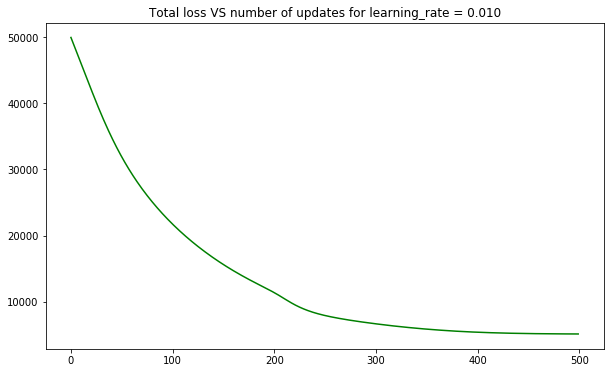

In [8]:
learning_rate = 0.01
points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(3, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 500
for itr in range(numIteration):
    loss_, _ = sess.run([loss, train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.3f"%(learning_rate))
plt.show()

<h3>1.1.3</h3>

Number of cluster: 1, loss: 79110.28
Number of cluster: 1, loss: 48838.28
Number of cluster: 1, loss: 39954.02
Number of cluster: 1, loss: 38506.54
Number of cluster: 1, loss: 38453.55
Number of cluster: 1, loss: 38453.48
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Number of cluster: 1, loss: 38453.49
Percentage for different clusters:
Total K is 1, cluster 0: 1.00
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


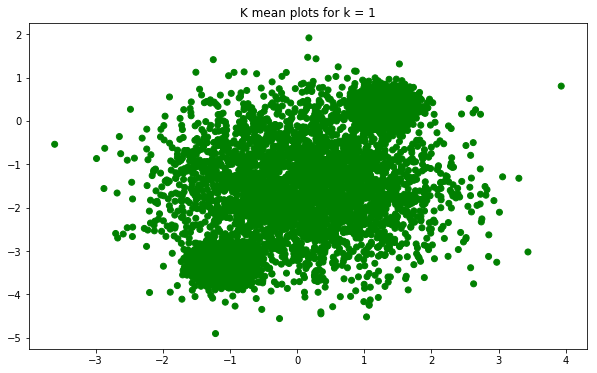

Number of cluster: 2, loss: 63469.20
Number of cluster: 2, loss: 28351.79
Number of cluster: 2, loss: 15129.37
Number of cluster: 2, loss: 10580.23
Number of cluster: 2, loss: 9371.68
Number of cluster: 2, loss: 9208.53
Number of cluster: 2, loss: 9203.37
Number of cluster: 2, loss: 9203.35
Number of cluster: 2, loss: 9203.36
Number of cluster: 2, loss: 9203.35
Percentage for different clusters:
Total K is 2, cluster 0: 0.50
Total K is 2, cluster 1: 0.50
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


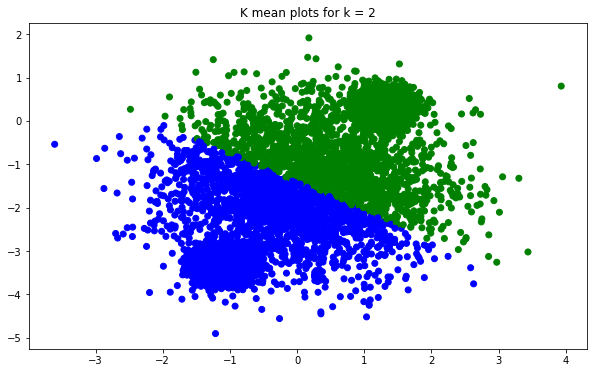

Number of cluster: 3, loss: 55134.23
Number of cluster: 3, loss: 24328.44
Number of cluster: 3, loss: 12597.96
Number of cluster: 3, loss: 7184.71
Number of cluster: 3, loss: 5582.89
Number of cluster: 3, loss: 5145.17
Number of cluster: 3, loss: 5111.32
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Number of cluster: 3, loss: 5111.07
Percentage for different clusters:
Total K is 3, cluster 0: 0.38
Total K is 3, cluster 1: 0.38
Total K is 3, cluster 2: 0.24
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


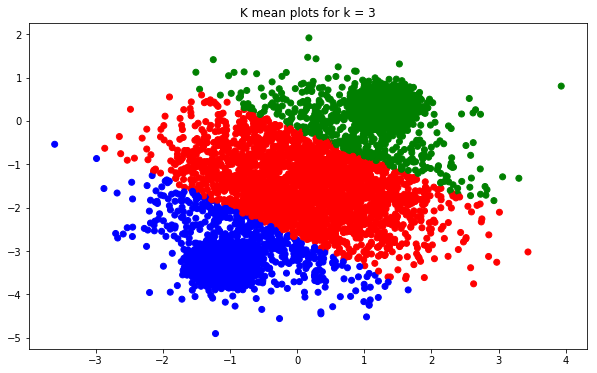

Number of cluster: 4, loss: 50871.99
Number of cluster: 4, loss: 22985.76
Number of cluster: 4, loss: 10039.87
Number of cluster: 4, loss: 5412.84
Number of cluster: 4, loss: 3737.19
Number of cluster: 4, loss: 3397.36
Number of cluster: 4, loss: 3374.14
Number of cluster: 4, loss: 3374.04
Number of cluster: 4, loss: 3374.03
Number of cluster: 4, loss: 3374.04
Percentage for different clusters:
Total K is 4, cluster 0: 0.13
Total K is 4, cluster 1: 0.37
Total K is 4, cluster 2: 0.37
Total K is 4, cluster 3: 0.12
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


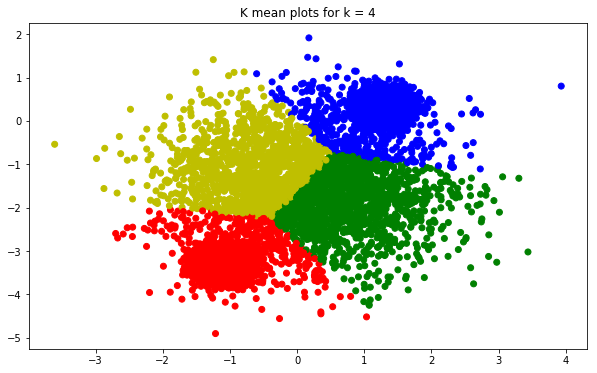

Number of cluster: 5, loss: 32920.80
Number of cluster: 5, loss: 12016.47
Number of cluster: 5, loss: 4723.19
Number of cluster: 5, loss: 3137.42
Number of cluster: 5, loss: 2890.58
Number of cluster: 5, loss: 2874.28
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Number of cluster: 5, loss: 2874.01
Percentage for different clusters:
Total K is 5, cluster 0: 0.09
Total K is 5, cluster 1: 0.07
Total K is 5, cluster 2: 0.36
Total K is 5, cluster 3: 0.12
Total K is 5, cluster 4: 0.36
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]
[ 1.69424762  1.12750805  2.40075462 ..., -1.11873012  1.58777283
  1.36922966]
[-2.4385797  -2.06013747 -2.96636567 ..., -3.41074163  0.14010238
  0.26141621]


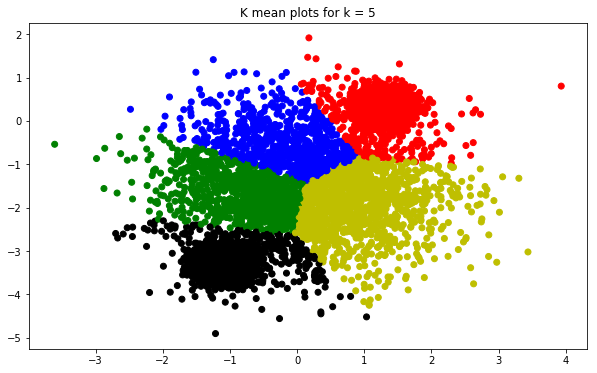

In [21]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])

    numIteration = 1000
    P = []
    assign = []
    for itr in range(numIteration):
        loss_, P, assign, _ = sess.run([loss, percentage, centroids_assign, train], feed_dict={points: points_2d})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, loss: %0.2f"%(K, loss_))
    print("Percentage for different clusters:")
    for k in range(K):
        print("Total K is %d, cluster %d: %0.2f"%(K, k, P[k][0])) 
    x = points_2d[:,0]
    y = points_2d[:,1]
    colors = [color_list[assign[i]] for i in range(Number_of_data)]
    plt.scatter(x,y,c=colors)
    #plt.axis([0,500, 0, 2])
    plt.title("K mean plots for k = %d"%(K))
    plt.show()

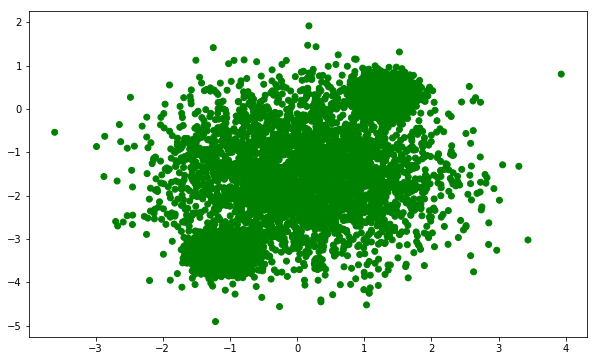

In [23]:
x = points_2d[:,0]
y = points_2d[:,1]
colors = ["g" for i in points_2d[:,0]]
plt.scatter(x,y,c=colors)

<h3>1.1.4</h3>

In [37]:
validSize = int(Number_of_data * 1.0 / 3.0)
validData = points_2d[:validSize,:]
trainData = points_2d[validSize:,:]
print(validData)

[[ 1.69424762 -2.4385797 ]
 [ 1.12750805 -2.06013747]
 [ 2.40075462 -2.96636567]
 ..., 
 [ 1.34861077  0.21586008]
 [-0.33089382 -2.13849022]
 [ 1.47810309  0.71745904]]


Number of cluster: 1, Iteration#: 0, Validation loss: 21494.57
Number of cluster: 1, Iteration#: 100, Validation loss: 14248.43
Number of cluster: 1, Iteration#: 200, Validation loss: 12833.39
Number of cluster: 1, Iteration#: 300, Validation loss: 12752.72
Number of cluster: 1, Iteration#: 400, Validation loss: 12753.20


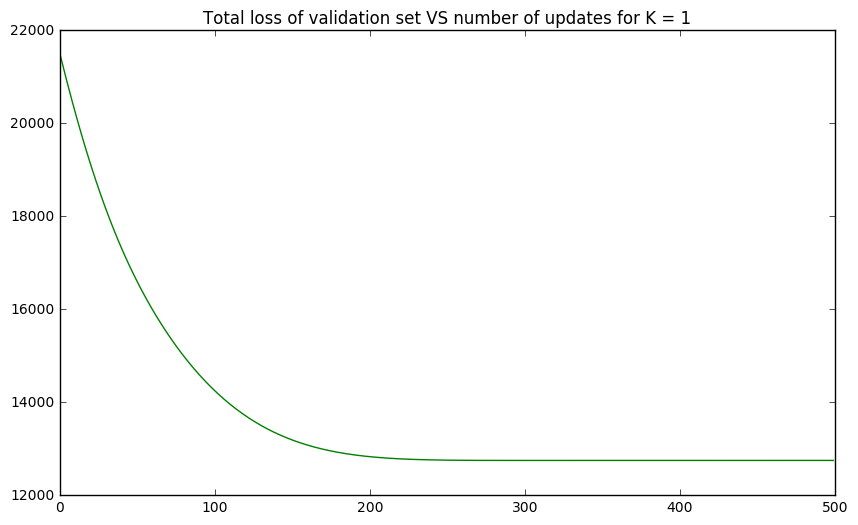

Number of cluster: 2, Iteration#: 0, Validation loss: 18969.51
Number of cluster: 2, Iteration#: 100, Validation loss: 8136.72
Number of cluster: 2, Iteration#: 200, Validation loss: 4489.36
Number of cluster: 2, Iteration#: 300, Validation loss: 3320.94
Number of cluster: 2, Iteration#: 400, Validation loss: 3050.72


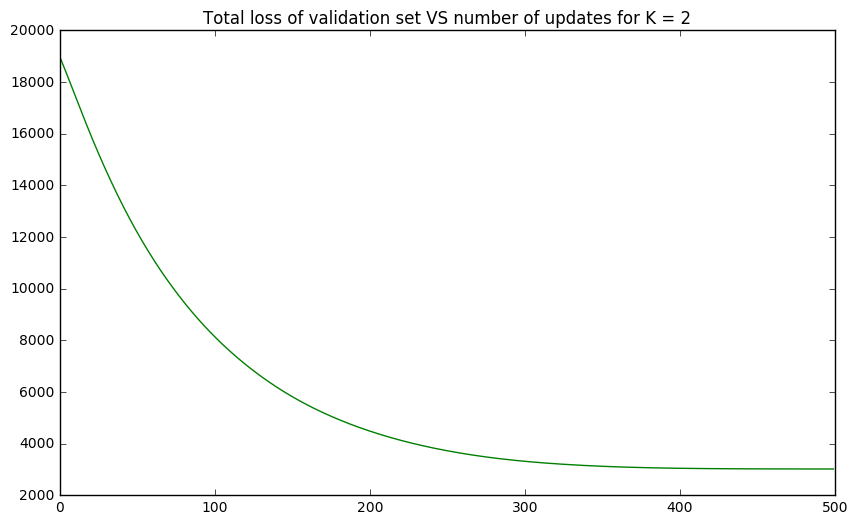

Number of cluster: 3, Iteration#: 0, Validation loss: 15694.48
Number of cluster: 3, Iteration#: 100, Validation loss: 6860.39
Number of cluster: 3, Iteration#: 200, Validation loss: 3233.75
Number of cluster: 3, Iteration#: 300, Validation loss: 2172.90
Number of cluster: 3, Iteration#: 400, Validation loss: 1729.28


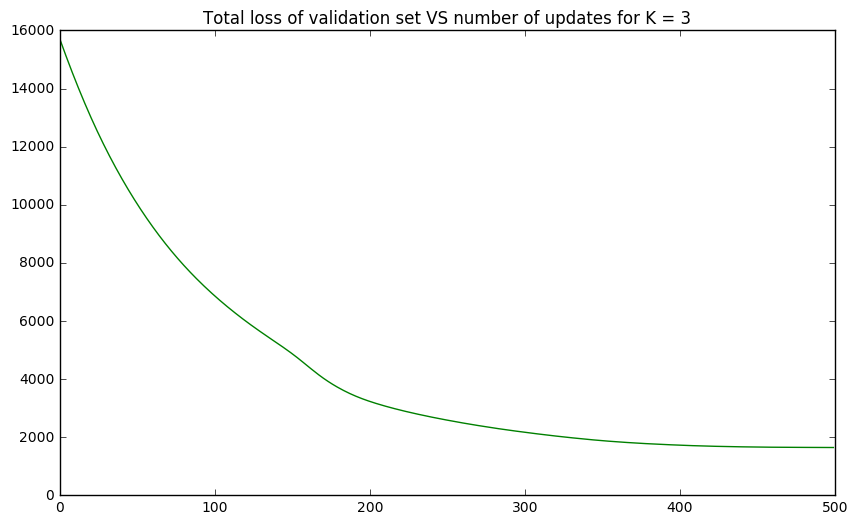

Number of cluster: 4, Iteration#: 0, Validation loss: 12580.76
Number of cluster: 4, Iteration#: 100, Validation loss: 5048.21
Number of cluster: 4, Iteration#: 200, Validation loss: 2290.29
Number of cluster: 4, Iteration#: 300, Validation loss: 1362.81
Number of cluster: 4, Iteration#: 400, Validation loss: 1131.13


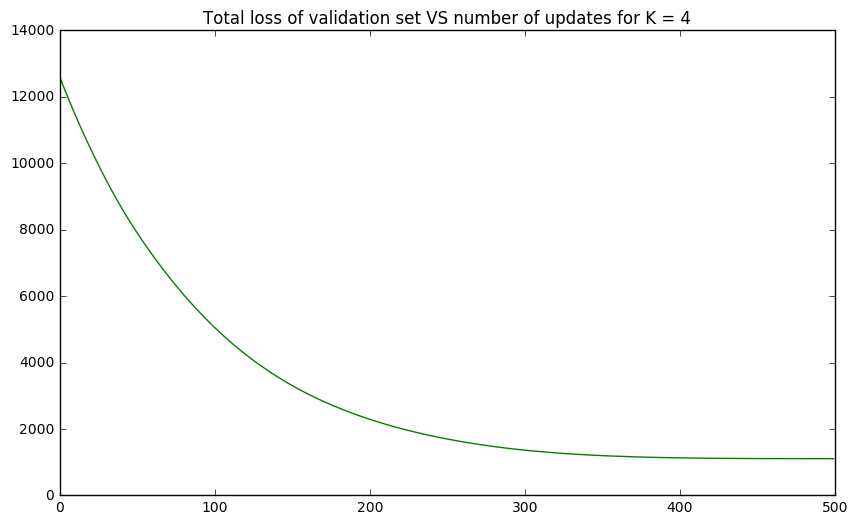

Number of cluster: 5, Iteration#: 0, Validation loss: 15599.42
Number of cluster: 5, Iteration#: 100, Validation loss: 6321.72
Number of cluster: 5, Iteration#: 200, Validation loss: 2709.74
Number of cluster: 5, Iteration#: 300, Validation loss: 1407.25
Number of cluster: 5, Iteration#: 400, Validation loss: 1019.40


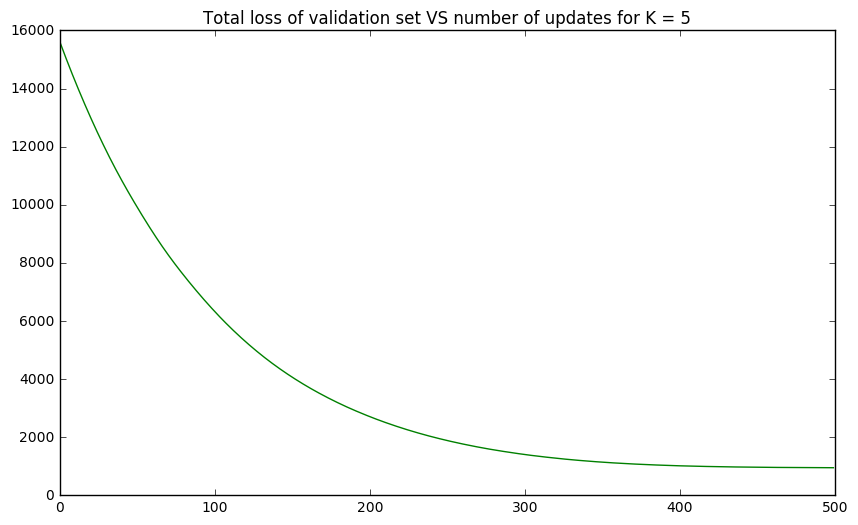

In [186]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, centroids, centroids_assign, loss, percentage, train = buildGraph_K_means_Adam(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 500
    for itr in range(numIteration):
        _ = sess.run([train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()

<h3>2.1.2</h3>

In [91]:
def get_log_gaussian(X, mu, diag_stdev):
    '''
    X: BxD
    mu: KxD
    diag_stdev: Kx1
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return BxK matrix
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_X = tf.reshape(tf.tile(X, [1, K]), [B, K, D])
    rep_diag_stdev = tf.reshape(tf.tile(diag_stdev, [1,D]), [K,D])
    dist = tf.contrib.distributions.MultivariateNormalDiag(mu, rep_diag_stdev)
    return dist.log_pdf(rep_X)
    

In [92]:
mu = tf.constant([[1.0,3.0],[5.0,2.0],[1.0,3.0]], dtype=tf.float64)
diag_stdev = tf.constant([[1.0], [1.0],[1.0]], dtype=tf.float64)
X = tf.placeholder(tf.float64, [None, 2])
dist = get_log_gaussian(X, mu, diag_stdev)

sess = tf.InteractiveSession()
sess.run(dist, feed_dict={X: points_2d})

array([[-16.86794151, -17.15237132, -16.86794151],
       [-14.64850181, -17.57833214, -14.64850181],
       [-20.61769351, -17.54830934, -20.61769351],
       ..., 
       [-24.63118986, -35.19536871, -24.63118986],
       [ -6.10012272,  -9.38913378,  -6.10012272],
       [ -5.65596292,  -9.94046048,  -5.65596292]])

<h3>2.1.3</h3>

In [109]:
def get_log_P_Z_given_X(X, pi, mu, diag_stdev):
    '''
    X: BxD
    pi: 1xK
    mu: KxD
    diag_stdev: Kx1
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return BxK matrix
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_pi = tf.reshape(tf.tile(pi, [1,B]), [B, K])
    log_gaussian = get_log_gaussian(X, mu, diag_stdev)
    res = logsoftmax(rep_pi + log_gaussian)
    return res
    

In [110]:
mu = tf.constant([[1.0,3.0],[5.0,2.0]], dtype=tf.float64)
diag_stdev = tf.constant([[1.0], [1.0]], dtype=tf.float64)
pi = logsoftmax(tf.constant([[0.5,0.5]], dtype=tf.float64))
X = tf.placeholder(tf.float64, [None, 2])
res = get_log_P_Z_given_X(X, pi, mu, diag_stdev)

sess = tf.InteractiveSession()
sess.run(res, feed_dict={X: points_2d})

array([[ -5.61010909e-01,  -8.45440722e-01],
       [ -5.20288178e-02,  -2.98185915e+00],
       [ -3.11478742e+00,  -4.54032457e-02],
       ..., 
       [ -2.58243746e-05,  -1.05642047e+01],
       [ -3.66122269e-02,  -3.32562329e+00],
       [ -1.36864553e-02,  -4.29818402e+00]])

<h3>2.2.2</h3>

In [98]:
def get_log_P(X, pi, mu, diag_stdev):
    '''
    X: BxD
    pi: 1xK
    mu: KxD
    diag_stdev: Kx1
    B: number of data points
    D: dimension of a data point
    K: number of clusters
    return float64
    '''
    B = tf.shape(X)[0]
    D = tf.shape(X)[1]
    K = tf.shape(mu)[0]
    rep_pi = tf.reshape(tf.tile(pi, [1,B]), [B, K])
    log_gaussian = get_log_gaussian(X, mu, diag_stdev)
    res = tf.reduce_sum(reduce_logsumexp(rep_pi + log_gaussian))
    return res

In [101]:
K = 2
mu = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='mu_test')
diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,1], stddev=0.5)), name='diag_stdev_test')
phi = tf.Variable(tf.div(tf.ones(shape=[1,K]), K), name='phi_test')
pi = logsoftmax(phi)
X = tf.placeholder(tf.float32, [None, 2])
res = get_log_P(X, pi, mu, diag_stdev)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
#sess.run(tf.shape(mu)[0])
sess.run(res, feed_dict={X: points_2d})

-47012.844

In [100]:
def buildGraph_MoG_Adam_2d(K, learning_rate):
    # Variable creation
    points = tf.placeholder(tf.float32, [None, 2], name='input_points')
    mu = tf.Variable(tf.truncated_normal(shape=[K,2], stddev=0.5), name='mu')
    diag_stdev = tf.Variable(tf.exp(tf.truncated_normal(shape=[K,1], stddev=0.5)), name='diag_stdev')
    phi = tf.Variable(tf.truncated_normal(shape=[1,K], stddev=0.5), name='phi')
    pi = logsoftmax(phi)
    
    # Loss definition
    loss = -get_log_P(points, pi, mu, diag_stdev)
    # Training mechanism
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1=0.9, beta2=0.99, epsilon=1e-5)
    train = optimizer.minimize(loss=loss)
    return points, pi, mu, diag_stdev, loss, train

Iteration#: 0, loss: 45236.34
Mean matrix is:
[[-0.58573604  0.28115284]
 [-0.56335515 -0.29273012]
 [ 0.20910101  0.19260454]]
diag_stdev is:
[[ 0.92919832]
 [ 1.37856269]
 [ 0.9158141 ]]
pi is:
[[-0.8604573 -1.4554888 -1.067855 ]]
Iteration#: 100, loss: 28727.54
Mean matrix is:
[[-0.09918427 -0.68286425]
 [-0.51847064 -1.11538708]
 [ 1.32307124  0.31452489]]
diag_stdev is:
[[ 1.53122234]
 [ 1.58262718]
 [ 0.19632642]]
pi is:
[[-1.4756521  -0.79795986 -1.13592839]]
Iteration#: 200, loss: 24757.35
Mean matrix is:
[[-0.11945412 -1.24625099]
 [-0.61096096 -2.05185795]
 [ 1.29833257  0.30730781]]
diag_stdev is:
[[ 1.39132369]
 [ 1.03079009]
 [ 0.19768533]]
pi is:
[[-2.11320639 -0.60268676 -1.10318959]]
Iteration#: 300, loss: 19878.46
Mean matrix is:
[[ 0.35134178 -1.24093235]
 [-1.08112478 -3.01370072]
 [ 1.29896009  0.30984819]]
diag_stdev is:
[[ 0.93465412]
 [ 0.34023872]
 [ 0.19595639]]
pi is:
[[-1.47819173 -0.82408112 -1.09867501]]
Iteration#: 400, loss: 17132.37
Mean matrix is:
[[ 0.

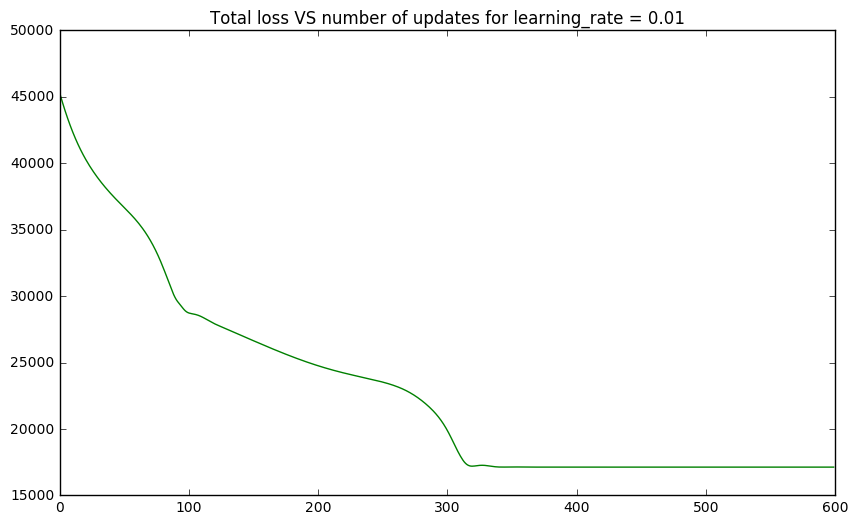

In [111]:
learning_rate = 0.01
points, pi, mu, diag_stdev, loss, train = buildGraph_MoG_Adam_2d(3, learning_rate)
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)
loss_recorder = np.array([])

numIteration = 600
best_pi = []
for itr in range(numIteration):
    loss_, best_pi, mu_, diag_stdev_, _ = sess.run([loss, pi, mu, diag_stdev, train], feed_dict={points: points_2d})
    loss_recorder = np.append(loss_recorder, loss_)
    if itr % 100 == 0:
        print("Iteration#: %d, loss: %0.2f"%(itr, loss_))
        print("Mean matrix is:")
        print(mu_)
        print("diag_stdev is:")
        print(diag_stdev_)
        print("pi is:")
        print(best_pi)
best_pi = sess.run(tf.exp(best_pi))
print("The best pi values are %0.2f, %0.2f, %0.2f"%(best_pi[0][0], best_pi[0][1], best_pi[0][2]))
plt.plot(np.arange(numIteration), loss_recorder, 'g')
#plt.axis([0,500, 0, 2])
plt.title("Total loss VS number of updates for learning_rate = %0.2f"%(learning_rate))
plt.show()

<h3>2.2.3</h3>

In [105]:
def get_MoG_assign(X, pi, mi, diag_stdev):
    assign = tf.argmax(get_log_P_Z_given_X(X, pi, mu, diag_stdev), 1)
    return assign

In [49]:
trainData.shape[0]

6667

Number of cluster: 1, Iteration#: 0, Validation loss: 13970.95
Number of cluster: 1, Iteration#: 100, Validation loss: 12355.57
Number of cluster: 1, Iteration#: 200, Validation loss: 11674.18
Number of cluster: 1, Iteration#: 300, Validation loss: 11620.95
Number of cluster: 1, Iteration#: 400, Validation loss: 11621.06


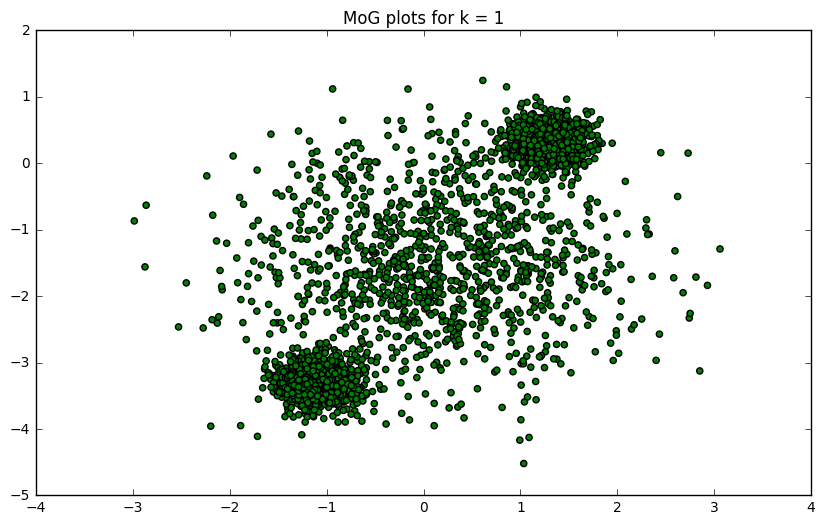

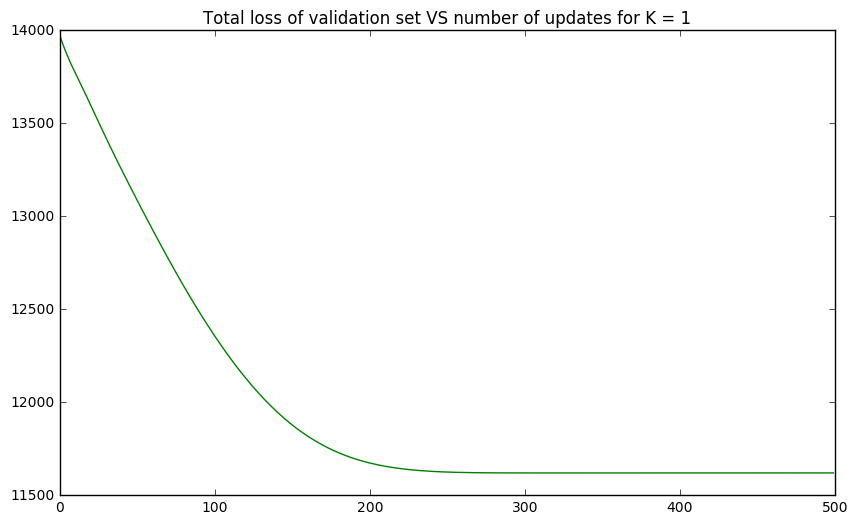

Number of cluster: 2, Iteration#: 0, Validation loss: 14180.81
Number of cluster: 2, Iteration#: 100, Validation loss: 11643.32
Number of cluster: 2, Iteration#: 200, Validation loss: 8194.42
Number of cluster: 2, Iteration#: 300, Validation loss: 8054.79
Number of cluster: 2, Iteration#: 400, Validation loss: 8054.95


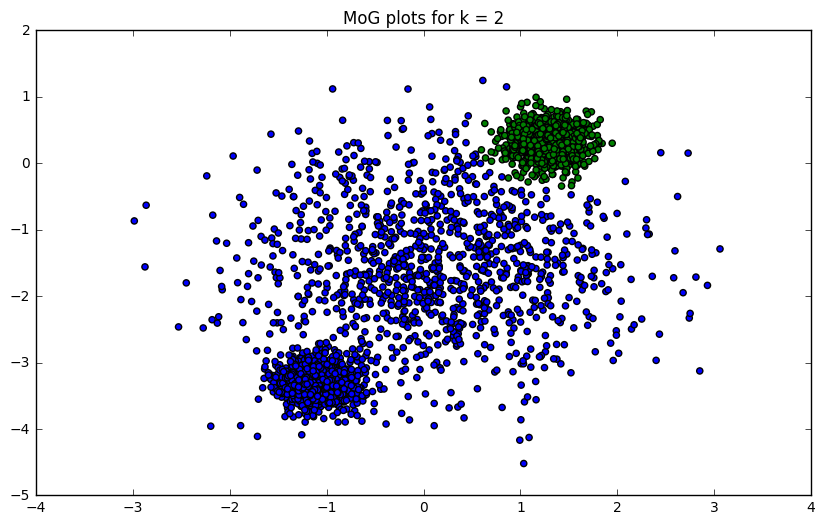

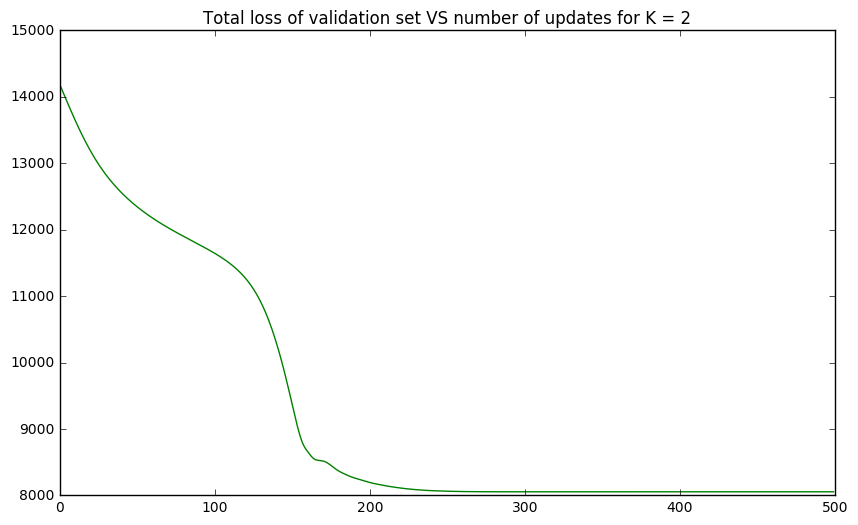

Number of cluster: 3, Iteration#: 0, Validation loss: 13931.05
Number of cluster: 3, Iteration#: 100, Validation loss: 9935.53
Number of cluster: 3, Iteration#: 200, Validation loss: 8379.87
Number of cluster: 3, Iteration#: 300, Validation loss: 7955.58
Number of cluster: 3, Iteration#: 400, Validation loss: 5756.00


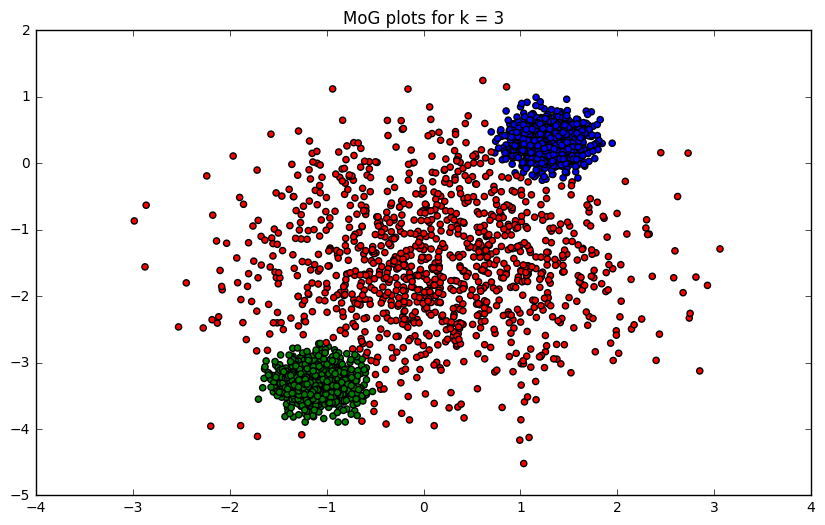

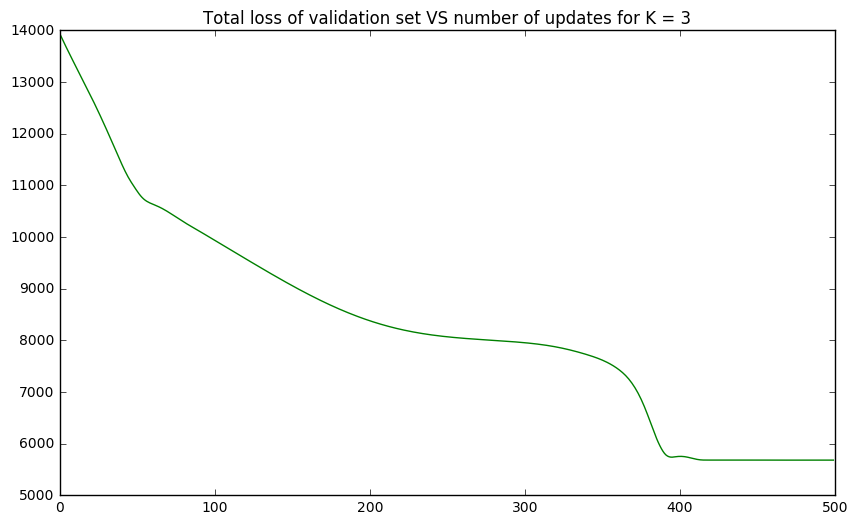

Number of cluster: 4, Iteration#: 0, Validation loss: 13760.20
Number of cluster: 4, Iteration#: 100, Validation loss: 10650.34
Number of cluster: 4, Iteration#: 200, Validation loss: 6375.71
Number of cluster: 4, Iteration#: 300, Validation loss: 5695.89
Number of cluster: 4, Iteration#: 400, Validation loss: 5684.03


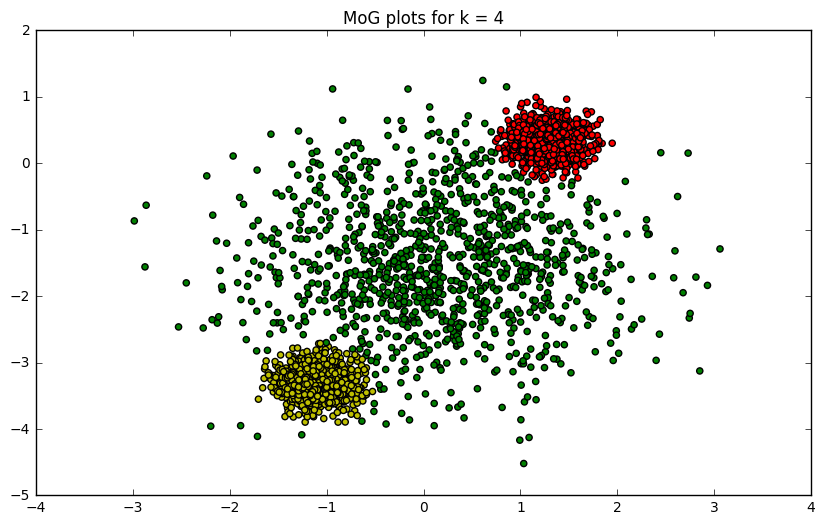

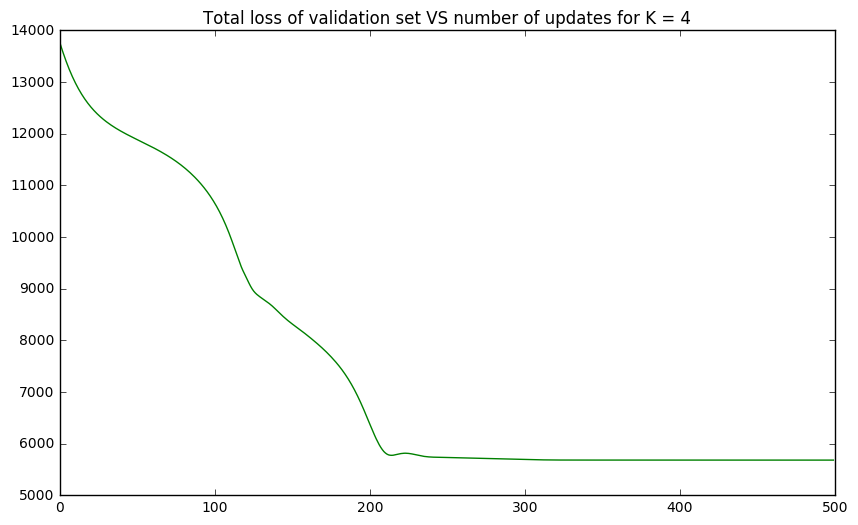

Number of cluster: 5, Iteration#: 0, Validation loss: 13766.01
Number of cluster: 5, Iteration#: 100, Validation loss: 8612.15
Number of cluster: 5, Iteration#: 200, Validation loss: 7700.39
Number of cluster: 5, Iteration#: 300, Validation loss: 5690.00
Number of cluster: 5, Iteration#: 400, Validation loss: 5685.23


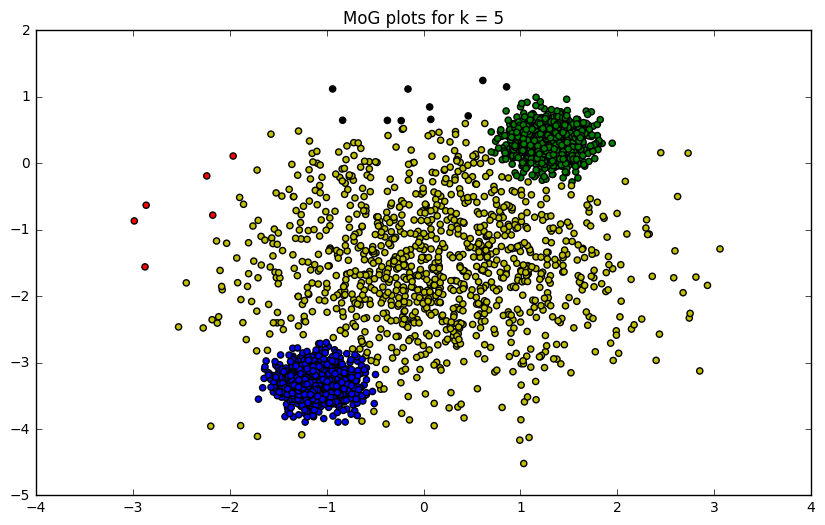

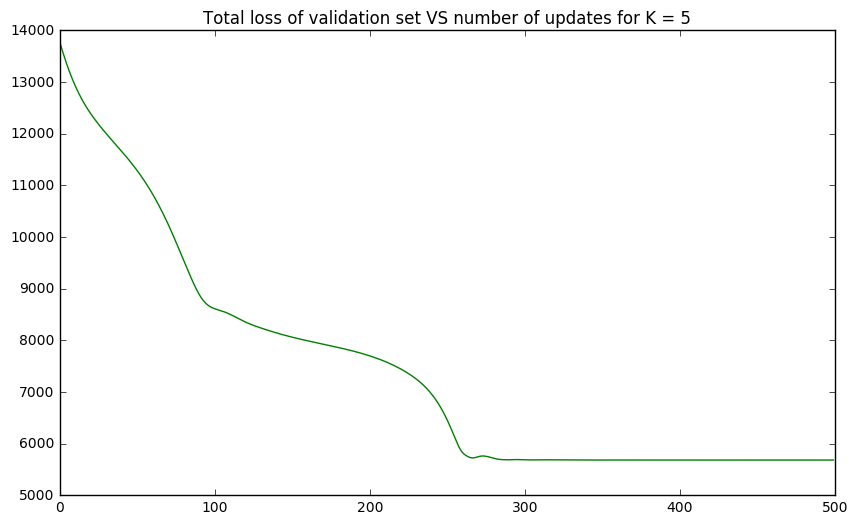

In [115]:
K_list = [1, 2, 3, 4, 5]
learning_rate = 0.01
color_list = ["g", "b", "r", "y", "k"]
for K in K_list:
    points, pi, mu, diag_stdev, loss, train = buildGraph_MoG_Adam_2d(K, learning_rate)
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    loss_recorder = np.array([])
    
    numIteration = 500
    pi_, mu_, diag_stdev_ = [], [], []
    for itr in range(numIteration):
        pi_,mu_,diag_stdev_,_ = sess.run([pi, mu, diag_stdev, train], feed_dict={points: trainData})
        loss_ = sess.run(loss, feed_dict={points: validData})
        loss_recorder = np.append(loss_recorder, loss_)
        if itr % 100 == 0:
            print("Number of cluster: %d, Iteration#: %d, Validation loss: %0.2f"%(K, itr, loss_))
            
    x = validData[:,0]
    y = validData[:,1]
    #print(pi_, mu_, diag_stdev_)
    assign = get_MoG_assign(points, pi_, mu_, diag_stdev_)
    assign = sess.run(assign, feed_dict={points: validData})
    #print(assign)
    colors = [color_list[assign[i]] for i in range(validData.shape[0])]
    plt.scatter(x,y,c=colors)
    #plt.axis([0,500, 0, 2])
    plt.title("MoG plots for k = %d"%(K))
    plt.show()
    
    plt.plot(np.arange(numIteration), loss_recorder, 'g')
    #plt.axis([0,500, 0, 2])
    plt.title("Total loss of validation set VS number of updates for K = %d"%(K))
    plt.show()